In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from scipy import ndimage 
tf.compat.v1.set_random_seed(1)

In [2]:
# ------------------------------------------- Utility Functions -------------------------------------------
""" Creates subsequences of the original sequence to fit LSTM structure
 
Args:
    sequence_1: the first sequence which gets converted into multiple subarrays of length: n_steps
    sequence_2: the second sequence, each n_steps'th element will be part of the output array
    n_steps: the amount of time steps used as an input into the LSTM for prediction

Returns:
    A tuple of 2 numpy arrays in the required format
    
    X.shape = (X.shape[0] - n_steps, n_steps)
    y.shape = (X.shape[0] - n_steps, 1)

"""
def subsequences(sequence_X, sequence_y, n_steps):
    if n_steps > len(sequence_X):
        raise Exception('subsequences: n_steps should not exceed the sequence length')
    
    X, y = list(), list()
    for i in range(len(sequence_X)):
        end_ix = i + n_steps

        if end_ix > len(sequence_X):
            break

        X.append(sequence_X[i:end_ix])
        y.append(sequence_y[end_ix-1])
        
    return np.array(X), np.array(y)


""" Subsample array to decrease the amount of data

Args:
    sequence: the input array to be subsampled
    d_sample: sample frequency, meaning every d_sample'th element will be part of the output
    
Returns:
    The subsampled array

"""
def subsample(sequence, d_sample):
    return sequence[::d_sample]


""" Smooth array to decrease measurement noise

Args: 
    sequence: the input array to be smoothed
    sigma: parameter for the gauss filtering

Returns:
    The smoothed array
"""
def smooth(sequence, sigma):
    return ndimage.filters.gaussian_filter(sequence, sigma)


""" Aligns two sequences

    In this context this means subsampling the first array so that it afterwards has the same size as the second array
    
Args: 
    sequence_1: arrray to be aligned
    sequence_2: array to be aligned to
    
Returns:
    The algined array
"""
def align(sequence_1, sequence_2):
    if len(sequence_1) < len(sequence_2):
        raise Exception('align: missmatch of sequence lengths')
    
    sample_ratio = sequence_1.shape[0] / sequence_2.shape[0]

    aligned_sequence = list()
    for i in range(len(sequence_2)):
        aligned_sequence.append(sequence_1[int(np.round(i * sample_ratio))])

    aligned_sequence = np.array(aligned_sequence)
    
    return aligned_sequence


""" Prepares the data for input into the LSTM

    Preparation incudes:
    subsampling, smoothing, aligning differnt sized sequences and reshaping the sequence to the requested format
    
Args:
    input_sequence: the input feature sequence
    label_sequence: the output/groud truth sequence
    aligned: indicates if input and label sequence are of equal size or need alignment
    d_sample: sample frequency
    n_steps: the amount of time steps used as an input into the LSTM for prediction
    sigma: parameter for the data smoothing

Returns:
    A tuple of 3 values. The prepared input sequence X, the output sequence of labels y and the scaler component for y. 
    This is needed afterwards to scale the output back to the original value range
"""
def prepare_data(input_sequence, label_sequence, aligned, d_sample, n_steps, sigma):
    # align data if not of equal size
    if not aligned:        
        input_sequence = align(input_sequence, label_sequence)

    # subsample and smooth data 
    input_sequence_ = subsample(input_sequence, d_sample)
    input_sequence_ = smooth(input_sequence_, sigma)
    
    label_sequence_ = subsample(label_sequence, d_sample)
    label_sequence_ = smooth(label_sequence_, sigma)

    # convert into X and y sequences
    X, y = subsequences(input_sequence_, label_sequence_, n_steps)
    y = np.reshape(y, (-1, 1))

    # fit and scale X
    scaler_X = MinMaxScaler(feature_range = (0, 1))
    scaler_X.fit(X)
    X_scaled = scaler_X.transform(X)

    # fit and scale y
    scaler_y = MinMaxScaler(feature_range = (0, 1))
    scaler_y.fit(y)
    y_scaled = scaler_y.transform(y)

    # reshape into correct format
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    
    return X_scaled, y_scaled, scaler_y

def prepare_data_unscaled(input_sequence, label_sequence, aligned, d_sample, n_steps, sigma):
    # align data if not of equal size
    if not aligned:        
        input_sequence = align(input_sequence, label_sequence)

    # subsample and smooth data 
    input_sequence_ = subsample(input_sequence, d_sample)
    input_sequence_ = smooth(input_sequence_, gauss_sigma)
    
    label_sequence_ = subsample(label_sequence, d_sample)
    label_sequence_ = smooth(label_sequence_, gauss_sigma)

    # convert into X and y sequences
    X, y = subsequences(input_sequence_, label_sequence_, n_steps)
    y = np.reshape(y, (-1, 1))

    # reshape into correct format
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    return X, y

In [12]:
# ------------------------------------------- Hyperparameters -------------------------------------------
n_steps = 50
n_features = 2
n_lstm_units_1 = 20
n_lstm_units_2 = 10
n_dense_units = 1
n_epochs = 5

d_sample = 1
gauss_sigma = 10

In [13]:
# ------------------------------------------- Prepare Training Data -------------------------------------------
# load data
train_cur_inv = np.loadtxt('../data/fobss_data/data/Profile 10A/inverter/Inverter_Current.csv', delimiter=';')
train_cur_inv = train_cur_inv[:,1]
train_volt_master = np.loadtxt('../data/fobss_data/data/Profile 10A/battery/Battery_Voltage.csv', delimiter=';')
train_volt_master = train_volt_master[:,1]
train_volt_slave_0_cell_4 = np.loadtxt('../data/fobss_data/data/Profile 10A/cells/Slave_0_Cell_Voltages.csv', delimiter=';')
train_volt_slave_0_cell_4 = train_volt_slave_0_cell_4[:,4]
train_volt_repeat = np.full(shape=train_volt_slave_0_cell_4.shape[0], fill_value=train_volt_slave_0_cell_4[0], dtype=np.float)

# prepare LSTM input
X1_train, y1_train, scaler_y = prepare_data(train_cur_inv, train_volt_slave_0_cell_4, False, d_sample, n_steps, gauss_sigma)

inv_cum = np.cumsum(train_cur_inv)

X2_train, y2_train, scaler_y = prepare_data(inv_cum, train_volt_slave_0_cell_4, False, d_sample, n_steps, gauss_sigma)
X_train = np.append(X1_train, X2_train, axis=2)
y_train = y1_train

print(X_train.shape, y_train.shape)

# ------------------------------------------- multiple profiles -------------------------------------------
cur_profile_1 = np.loadtxt('../data/fobss_data/data/Profile 10A/inverter/Inverter_Current.csv', delimiter=';')
cur_profile_1 = cur_profile_1[:,1]
volt_profil_1 = np.loadtxt('../data/fobss_data/data/Profile 10A/cells/Slave_0_Cell_Voltages.csv', delimiter=';')
volt_profil_1 = volt_profil_1[:,4]

cur_profile_2 = np.loadtxt('../data/fobss_data/data/Profile 10A/inverter/Inverter_Current.csv', delimiter=';')
cur_profile_2 = cur_profile_2[:,1]
volt_profil_2 = np.loadtxt('../data/fobss_data/data/Profile 10A/cells/Slave_0_Cell_Voltages.csv', delimiter=';')
volt_profil_2 = volt_profil_2[:,4]

cur_profile_3 = np.loadtxt('../data/fobss_data/data/Profile 25A/inverter/Inverter_Current.csv', delimiter=';')
cur_profile_3 = cur_profile_3[:,1]
volt_profil_3 = np.loadtxt('../data/fobss_data/data/Profile 25A/cells/Slave_0_Cell_Voltages.csv', delimiter=';')
volt_profil_3 = volt_profil_3[:,4]

cur_profile_4 = np.loadtxt('../data/fobss_data/data/Profile 25A/inverter/Inverter_Current.csv', delimiter=';')
cur_profile_4 = cur_profile_4[:,1]
volt_profil_4 = np.loadtxt('../data/fobss_data/data/Profile 25A/cells/Slave_0_Cell_Voltages.csv', delimiter=';')
volt_profil_4 = volt_profil_4[:,4]

cur_profile_1 = align(cur_profile_1, cur_profile_1)
cur_profile_1 = cur_profile_1[:2000]
volt_profil_1 = volt_profil_1[:2000]

cur_profile_2 = align(cur_profile_2, cur_profile_2)
cur_profile_2 = cur_profile_2[:2000]
volt_profil_2 = volt_profil_2[:2000]

cur_profile_3 = align(cur_profile_3, cur_profile_3)
cur_profile_3 = cur_profile_3[:2000]
volt_profil_3 = volt_profil_3[:2000]

cur_profile_4 = align(cur_profile_4, cur_profile_4)
cur_profile_4 = cur_profile_4[:2000]
volt_profil_4 = volt_profil_4[:2000]


X1_train, y1_train, scaler_y = prepare_data(cur_profile_1, volt_profil_1, True, d_sample, n_steps, gauss_sigma)
X2_train, y2_train, scaler_y = prepare_data(cur_profile_2, volt_profil_2, True, d_sample, n_steps, gauss_sigma)
X3_train, y3_train, scaler_y = prepare_data(cur_profile_3, volt_profil_3, True, d_sample, n_steps, gauss_sigma)
X4_train, y4_train, scaler_y = prepare_data(cur_profile_4, volt_profil_4, True, d_sample, n_steps, gauss_sigma)

X12_train = np.append(X1_train, X2_train, axis=0)
X123_train = np.append(X12_train, X3_train, axis=0)
X1234_train = np.append(X123_train, X4_train, axis=0)

y12_train = np.append(y1_train, y2_train, axis=0)
y123_train = np.append(y12_train, y3_train, axis=0)
y1234_train = np.append(y123_train, y4_train, axis=0)

# print(X1234_train.shape, y1234_train.shape)

(2951, 50, 2) (2951, 1)


In [ ]:
# sample code for autoencoder
latent_dim = 16

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(
    shape=(window_len, n_total_features), name='past_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(past_inputs)

future_inputs = tf.keras.Input(
    shape=(forecast_len, n_deterministic_features), name='future_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True)
x = decoder_lstm(future_inputs,
                 initial_state=[state_h, state_c])

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(
    inputs=[past_inputs, future_inputs], outputs=output)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.Huber()
model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])

In [14]:
# ------------------------------------------- Initialize LSTM -------------------------------------------
model = keras.Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(layers.LSTM(units = n_lstm_units_1, activation='relu', input_shape = (n_steps, n_features), return_sequences=True))

model.add(layers.LSTM(units = n_lstm_units_2))

# Adding the output layer
model.add(layers.Dense(units = n_dense_units))

# Show model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 20)            1840      
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 3,091
Trainable params: 3,091
Non-trainable params: 0
_________________________________________________________________


In [15]:
# ------------------------------------------- Train LSTM -------------------------------------------
model.compile(optimizer = 'RMSprop', loss = 'mse')

# Fitting the LSTM to the Training set
history = model.fit(X_train, y_train, epochs = n_epochs, verbose = 1)

Epoch 1/5
93/93 [==============================] - 2s 17ms/step - loss: 0.0312
Epoch 2/5
93/93 [==============================] - 2s 17ms/step - loss: 0.0017
Epoch 3/5
93/93 [==============================] - 1s 16ms/step - loss: 0.0016
Epoch 4/5
93/93 [==============================] - 2s 16ms/step - loss: 0.0014
Epoch 5/5
93/93 [==============================] - 2s 16ms/step - loss: 0.0012


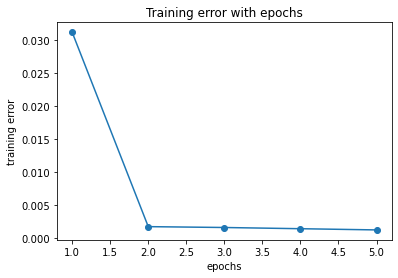

In [16]:
# ------------------------------------------- Visualize Training -------------------------------------------
loss = history.history['loss']
epochs = range(1,len(loss)+1)

plt.title('Training error with epochs')
plt.plot(epochs,loss,'-o',label='training loss')
plt.xlabel('epochs')
plt.ylabel('training error')
plt.show()

In [17]:
# ------------------------------------------- Prepare Test Data -------------------------------------------
# load data
test_cur_inv = np.loadtxt('../data/fobss_data/data/Profile 10A/inverter/Inverter_Current.csv', delimiter=';')
test_cur_inv = test_cur_inv[:,1]
test_volt_master = np.loadtxt('../data/fobss_data/data/Profile 10A/battery/Battery_Voltage.csv', delimiter=';')
test_volt_master = test_volt_master[:,1]
test_volt_slave_0_cell_4 = np.loadtxt('../data/fobss_data/data/Profile 10A/cells/Slave_0_Cell_Voltages.csv', delimiter=';')
test_volt_slave_0_cell_4 = test_volt_slave_0_cell_4[:,4]
test_volt_repeat = np.full(shape=test_volt_slave_0_cell_4.shape[0], fill_value=test_volt_slave_0_cell_4[0], dtype=np.float)

# prepare prediction
X1_test, y_test1, scaler_y = prepare_data(test_cur_inv, test_volt_slave_0_cell_4, False, d_sample, n_steps, gauss_sigma)
# X2_test, y_test2 = prepare_data_unscaled(test_volt_repeat, test_volt_slave_0_cell_4, False, d_sample, n_steps, gauss_sigma)
# X_test = np.append(X1_test, X2_test, axis=2)
# y_test_unscaled = y_test2

print(X1_test.shape, y_test1.shape)

(2951, 50, 1) (2951, 1)


93/93 [==============================] - 0s 4ms/step


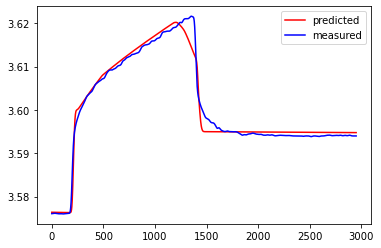

In [19]:
# predict on test data
yhat = model.predict(X_train, verbose = 1)

# unscale data for visualization
yhat_rescaled = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(y_train)
# plot test results
plt.plot(yhat_rescaled, color='red', label = 'predicted')
plt.plot(y_test_unscaled, color='blue', label = 'measured')
plt.legend()
plt.show()